<a href="https://colab.research.google.com/github/shayan823/CN-courses/blob/main/Build_a_Generative_Adversarial_Network_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning with PyTorch : Build a Generative Adversarial Network 

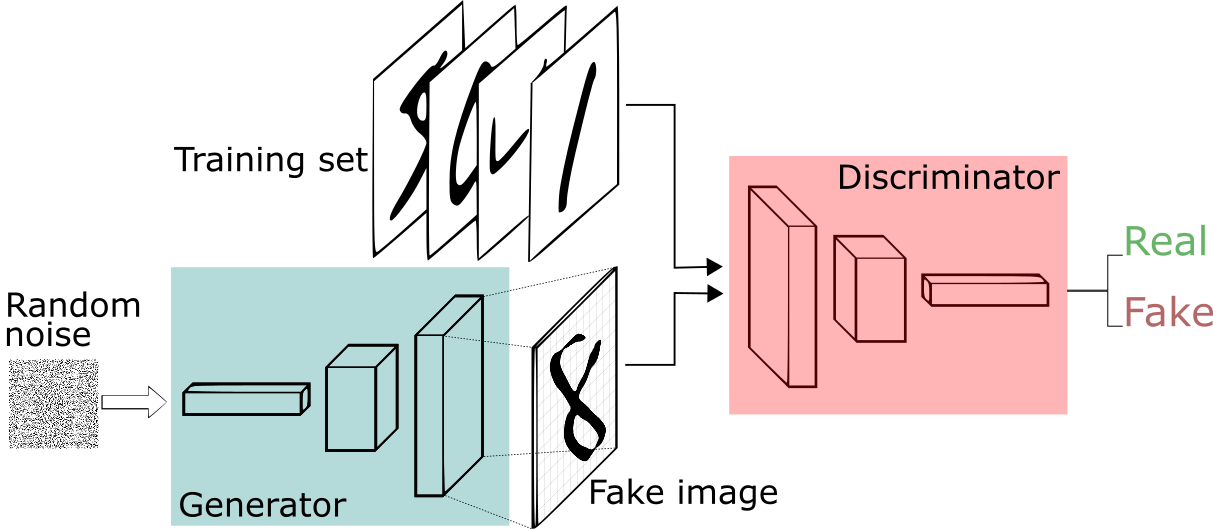

In [1]:
import torch 
torch.manual_seed(42)
import numpy as np 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm

# Configurations

In [2]:
device = 'cuda'
batch_size = 128
noise_dim = 64

# Optimization paramters
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

# Training variables
epochs = 20

# Load MNIST Dataset 

In [3]:
from torchvision import datasets, transforms as T

In [14]:
train_augs = T.Compose([
    T.RandomRotation((-20,20)),
                     T.ToTensor()
])

In [15]:
trainset = datasets.MNIST('MNIST/', download=True, train=True, transform=train_augs)

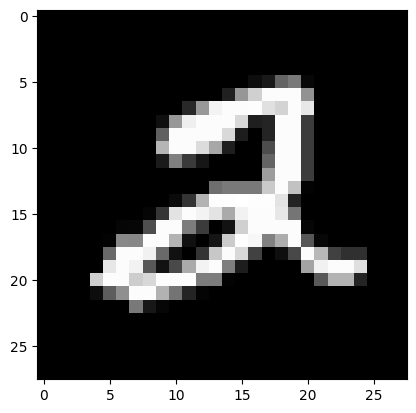

In [16]:
image, label = trainset[5]
plt.imshow(image.squeeze(), cmap='gray')

# Load Dataset Into Batches 

In [18]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [19]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
print(len(trainloader))

469


In [32]:
dataiter = iter(trainloader)
images, _ = next(dataiter)
print(images.shape)

torch.Size([128, 1, 28, 28])


In [33]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

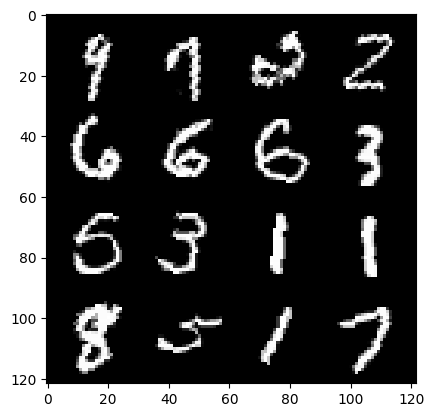

In [34]:
show_tensor_images(images)

# Create Discriminator Network 

In [35]:
#In case if torch summary is not installed 

!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
from torch import nn
from torchsummary import summary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

In [37]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [39]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.block_1 = get_disc_block(1, 16, (3,3), 2)
    self.block_2 = get_disc_block(16, 32, (5,5), 2)
    self.block_3 = get_disc_block(32, 64, (5,5), 2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features = 64, out_features = 1)

  def forward(self, images):
    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)

    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5

In [41]:
D = Discriminator()
D.to(device)

summary(D, input_size = (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network 

In [ ]:
'''

Network : Generator 

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) 
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

In [43]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block=False):
  if final_block == True:
    return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.Tanh()
  )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [44]:
class Generator(nn.Module):
  def __init__(self, noise_dim):
    super(Generator, self).__init__()

    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
    self.block_2 = get_gen_block(256, 128, (4,4), 1)
    self.block_3 = get_gen_block(128, 64, (3,3), 2)
    self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block=True)
  
  def forward(self, r_noise_vec):
    x = r_noise_vec.view(-1, self.noise_dim, 1, 1)
    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4

In [45]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size=(1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
      BatchNorm2d-11            [-1, 1, 28, 28]               2
             Tanh-12            [-1, 1, 28, 28]               0
Total params: 747,843
Trainable params: 747,843
Non-trainable params: 0
-------------------------------

In [46]:
# Replace Random initialized weights to Normal weights  

def weights_init(m):  
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [48]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [50]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [51]:
D_opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta_1, beta_2))

# Training Loop 

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1 | D_loss: 0.6659192087045357 | G_loss: 0.7342099857482829


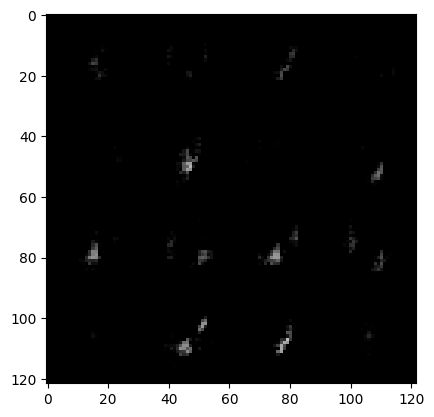

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 2 | D_loss: 0.5785461317247419 | G_loss: 0.812175802711739


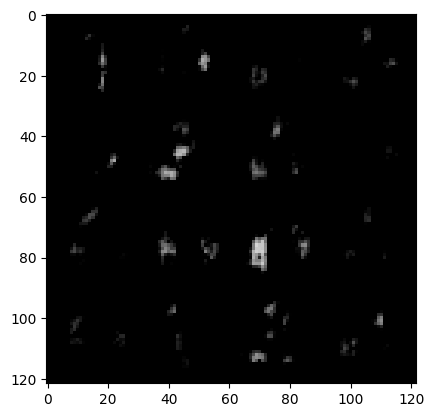

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 3 | D_loss: 0.4841842275184355 | G_loss: 0.9564479864609521


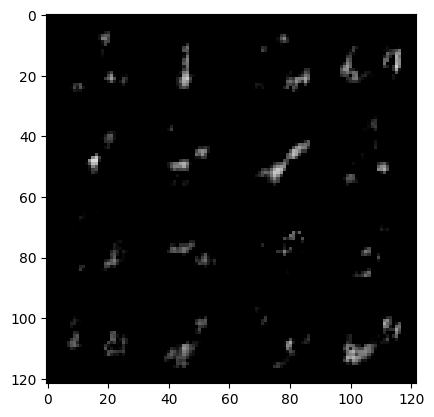

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 4 | D_loss: 0.3994707981152321 | G_loss: 1.1155955609736412


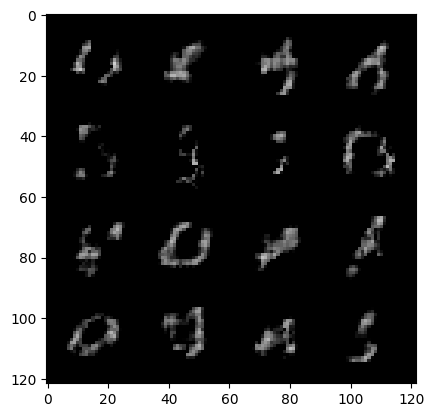

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 5 | D_loss: 0.5044083993063807 | G_loss: 0.9897722897372012


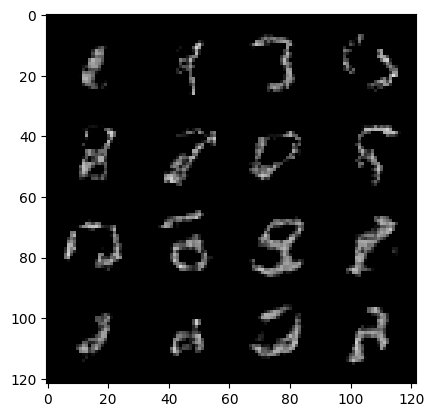

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 6 | D_loss: 0.6585104704411553 | G_loss: 0.7565730048903524


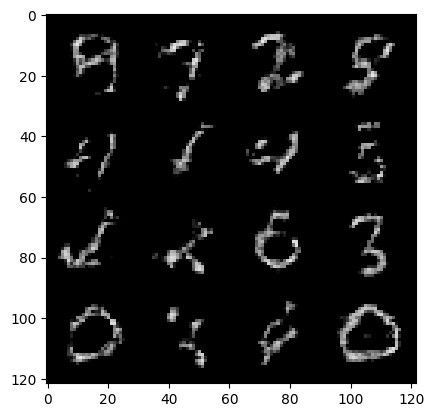

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 7 | D_loss: 0.6770352929639918 | G_loss: 0.7292910030147414


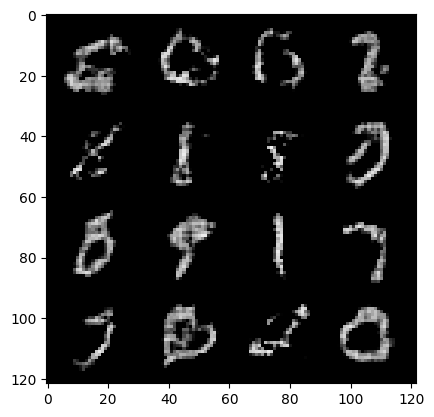

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 8 | D_loss: 0.6686554599418315 | G_loss: 0.7401660646456899


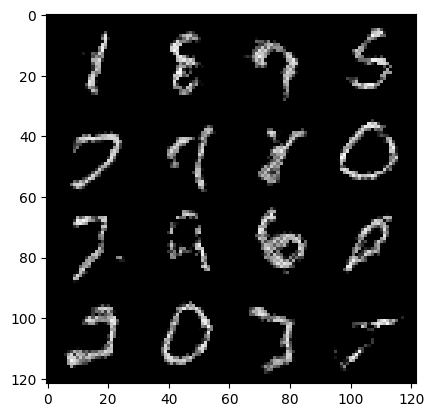

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
for i in range(epochs):

  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img, _ in tqdm(trainloader):
    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device=device)

    D_opt.zero_grad()

    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss)/2
    total_d_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()


    G_opt.zero_grad()
    noise = torch.randn(batch_size, noise_dim, device=device)
    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)
    total_g_loss += G_loss.item()

    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss / len(trainloader)
  avg_g_loss = total_g_loss / len(trainloader)

  print("Epoch: {} | D_loss: {} | G_loss: {}".format(i+1, avg_d_loss, avg_g_loss))

  show_tensor_images(fake_img)

In [ ]:

# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya